## E-76 Obligated Federal Funds Data Analysis

E-76 Obligated Federal Funds Data Exploration
From the Division of Local Assistance
E-76's or "Authorizations to Proceed" is a federal authorization of funds to establish the reimbursement date for a phase of work

#### Question
- What types of projects are being funded?
- Is there a type of funding that is more likely to be approved?
- What is the most/least common type of funding

#### Data Sources:¶
* [Waiting dataset](https://dot.ca.gov/programs/local-assistance/reports/e-76-waiting)
* [Obligated dataset](https://dot.ca.gov/programs/local-assistance/reports/e-76-obligated)

In this notebook, we will conduct analysis to determine what types of projects are funded through DLA

In [ ]:
## one time download
#! pip install plotnine

In [1]:
import pandas as pd
from siuba import _, mutate, count, filter, group_by, ungroup, summarize, show_query

import numpy as np
from sqlalchemy import create_engine
from siuba.sql import LazyTbl

In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = "{:.2f}".format

In [4]:
df = pd.read_csv('gs://calitp-analytics-data/data-analyses/dla/e-76Obligated/clean_obligated_waiting.csv', low_memory=False)


In [6]:
df.head()

,Unnamed: 0,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode
0,0,Obligated,BPMPL,5904(121),Humboldt County,2018-12-18,2018-12-18,2018-12-18,2018-12-18,2018-12-27,0.00,0.00,0.00,Authorized,5904,1,E-76 approved on,NaN,0.00,9.00,HBPLOCAL,14 Bridges In Humboldt County,Bridge Preventive Maintenance - Deck Joints,3,NaN,NaN,NON-MPO,NaN,5904,121,True
1,1,Obligated,ER,32D0(008),Mendocino County,2018-12-17,2018-12-19,2018-12-20,2018-12-20,2018-12-27,11508.00,0.00,13000.00,Authorized,5910,1,E-76 approved on,1.00,1.00,7.00,NaN,"Comptche Ukiah Road, Cr 223 Pm 17.25",Permanent Restoration,3,2018-12-17,2018-12-18,NON-MPO,NaN,32D0,8,False
2,2,Obligated,ER,4820(004),Humboldt County,2018-12-07,2018-12-21,2018-12-21,2018-12-21,2018-12-27,45499.64,0.00,51394.58,Authorized,5904,1,E-76 approved on,14.00,0.00,6.00,NaN,Mattole Rd Pm 43.17,Permanent Restoration,5,2018-12-06,2018-12-07,NON-MPO,NaN,4820,4,False
3,3,Obligated,CML,5924(244),Sacramento County,2018-12-11,2018-12-11,2018-12-21,2018-12-27,2018-12-27,207002.00,0.00,247002.00,Authorized,5924,3,E-76 approved on,4.00,16.00,0.00,SAC25086,Fair Oaks Blvd. Between Howe Ave And Munroe St,Create A Smart Growth Corridor With Barrier Se...,1,2018-12-07,2018-12-07,SACOG,NaN,5924,244,True
4,4,Obligated,CML,5924(214),Sacramento County,2018-12-05,2018-12-11,2018-12-21,2018-12-27,2018-12-27,0.00,5680921.00,5702041.00,Authorized,5924,3,E-76 approved on,7.00,16.00,0.00,SAC24753,Florin Rd Between Power Inn Rd. And Florin Per...,Streetscape (tc),3,2018-11-28,2018-12-04,SACOG,NaN,5924,214,True


In [9]:
df.sample(5)

,Unnamed: 0,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode
20029,20031,DISTRICT,BPMPL,5903(059),Modoc County,2021-06-30,NaN,NaN,NaN,NaN,39148.46,0.00,46134.65,8/13 PROJ CMPLT; PED LAPSED 10/31/20; NO WAIV...,5903,2,Prepared on 6/30/2021,NaN,NaN,NaN,NaN,Various Bridge Locations Within Modoc County,Bridge Preventive Maintenance,4,NaN,NaN,NON-MPO,NaN,5903,59,True
332,332,Obligated,CMSTPL,5174(029),Holtville,2018-10-24,2018-10-24,2018-10-24,2018-10-31,2018-11-02,-17092.68,0.00,-17807.17,Authorized,5174,11,E-76 approved on,NaN,7.00,2.00,IMP160403,9th Street From Palm Avenue To Olive Avenue,"Construction Curb & Gutter, Sidewalk, And Full...",5,NaN,NaN,SCAG,NaN,5174,29,True
8417,8417,Obligated,STP,5187(007),Colfax,2015-08-17,2015-08-17,2015-08-17,2015-08-24,2015-08-24,0.00,0.00,-28106.00,Authorized,5187,3,E-76 approved on E-76 approved on,0.00,7.00,0.00,VAR79030,Grass Valley Street West Of South Auburn St,Ped Improvements And Road Rehab,2,NaN,NaN,SACOG,NaN,5187,7,True
19538,19540,Obligated,CML,5216(054),Reedley,2021-07-13,2021-07-15,2021-07-19,2021-07-20,2021-07-26,107676.00,0.00,121627.00,Authorized,5216,6,E-76 approved on,3.00,5.00,6.00,FRE190008,Westside Of Reed Ave; I Street To 8th Street,"Install Sidewalks, Including: Replace Driveway...",3,2021-07-12,2021-07-13,CFCG,NaN,5216,54,True
16403,16405,Obligated,BHLSZ,5109(166),Bakersfield,2020-04-13,2020-04-14,2020-04-18,2020-04-20,2020-04-27,0.00,0.00,0.00,Authorized,5109,6,E-76 approved on,1.00,6.00,7.00,KER060601,Bridges 50c0021 L & R Manor Street Bridges Nb ...,Seismic Retrofit And Bridge Rehabilitation,6,2020-04-13,2020-04-14,KCOG,NaN,5109,166,True


In [8]:
df.mpo.unique()

array(['NON-MPO', 'SACOG', 'MTC', 'TCAG', 'KCOG', 'CFCG', 'SCAG', 'BCAG',
       'SLAC', 'STANCOG', 'SJCG', 'SDAG', 'KCAG', 'SBCG', 'MCAG', 'TMPO',
       'AMBAG', 'MCTC', 'STPA', 'COFCG', 'FCOG', 'ER NONE', 'SHASTA',
       'MNOLTC', 'SJCOG', 'STACOG', 'STNCOG', 'NONMPO', 'FSTIP', 'SANDAG',
       'SANDA', 'SLOCOG', nan], dtype=object)

## Prefix Dive
Many duplicates in the prefix column, cleanded and condensed the visible ones in the cleaning notebook but will need further cleanups and confirmations for the prefix codes that are grouped together. 

In [10]:
df.prefix.nunique()

335

In [11]:
print(sorted(df['prefix'].unique()))

['6140000', 'ACNHPI', 'ACST-ER', 'ACSTP', 'ASCTP', 'ATCMTD', 'ATF5512', 'ATP', 'ATPCML', 'ATPHIPL', 'ATPHSIP', 'ATPLN', 'ATPLNI', 'ATPLSB1', 'ATPNIL', 'ATPSB1', 'ATPSB1L', 'ATPSTC', 'ATPSTCML', 'ATPSTPL', 'BDGL', 'BGFL', 'BHL', 'BHLO', 'BHLOZ', 'BHLOZD', 'BHLS', 'BHLSCR', 'BHLSP', 'BHLSZ', 'BHLSZD', 'BPMPL', 'BR', 'BR-NBISL', 'BRCMLO', 'BRHIPL', 'BRIM', 'BRL', 'BRLKS', 'BRLNS', 'BRLO', 'BRLOZ', 'BRLOZA', 'BRLOZB', 'BRLOZE', 'BRLRT', 'BRLS', 'BRLSN', 'BRLSZ', 'BRLSZA', 'BRLSZD', 'BRLZ', 'BRNBIF', 'BRNBISL', 'BROS', 'BUILDL', 'CASB', 'CFLBRLO', 'CMAQL', 'CMESPL', 'CMFERP', 'CMFERP16', 'CMHIPL', 'CMHPLU', 'CMHPLULN', 'CMHRL', 'CMHSIPL', 'CML', 'CMLFSP', 'CMLFSP18', 'CMLFTA', 'CMLG', 'CMLGNI', 'CMLHPL', 'CMLN', 'CMLNGI', 'CMLNI', 'CMLSBCG', 'CMLSTBGL', 'CMRPSTPL', 'CMSTPL', 'CMSTPLN', 'CMSTPLNI', 'CMTCIFL', 'CMTCIFLN', 'CMTLSP', 'CRDL', 'CRP', 'CRRSAA', 'DBF', 'DBPL02', 'DE', 'DEM', 'DEM04L', 'DEM05', 'DEM05L', 'DEM05LN', 'DEM05U', 'DEM05UBL', 'DEM06', 'DEM06L', 'DEM06U', 'DEM06UBL', 'DEM0

In [15]:
df.prefix.value_counts()

HSIP       3367
CML        3334
STP        2817
ER         1607
BRLO       1416
           ... 
BROS          1
ITS13         1
FBDLNI        1
TCIFESP       1
FTACRRS       1
Name: prefix, Length: 335, dtype: int64

Made a slight dent, will need more cleaning

In [14]:
df.prefix.value_counts().sort_index(ascending=True)

6140000       2
ACNHPI        2
ACST-ER     238
ACSTP       317
ASCTP         1
           ... 
USFSSTPL      4
VPPL         19
VPPP          8
VPPTCS        1
WZDXL20       1
Name: prefix, Length: 335, dtype: int64

### How do funds look when we groupby Project type 


In [32]:
#using siuba to group
df_grouped = (df
  >> group_by(_.prefix)
  >> summarize(averge_funds = _.total_requested.mean())
  )


In [33]:
df_grouped.head()

,prefix,averge_funds
0,6140000,645621.50
1,ACNHPI,14713175.00
2,ACST-ER,491842.88
3,ACSTP,335628.39
4,ASCTP,15000.00


In [34]:
#adding count row
df_grouped >> count(_.prefix)

,prefix,n
0,6140000,1
1,ACNHPI,1
2,ACST-ER,1
3,ACSTP,1
4,ASCTP,1
...,...,...
330,USFSSTPL,1
331,VPPL,1
332,VPPP,1
333,VPPTCS,1


In [35]:
df_grouped.head()

,prefix,averge_funds
0,6140000,645621.50
1,ACNHPI,14713175.00
2,ACST-ER,491842.88
3,ACSTP,335628.39
4,ASCTP,15000.00


In [36]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   prefix        335 non-null    object 
 1   averge_funds  335 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.4+ KB


#### Queries with Siuba

In [37]:
df >> group_by(_.prefix)

,Unnamed: 0,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode
0,0,Obligated,BPMPL,5904(121),Humboldt County,2018-12-18,2018-12-18,2018-12-18,2018-12-18,2018-12-27,0.00,0.00,0.00,Authorized,5904,1,E-76 approved on,NaN,0.00,9.00,HBPLOCAL,14 Bridges In Humboldt County,Bridge Preventive Maintenance - Deck Joints,3,NaN,NaN,NON-MPO,NaN,5904,121,True
1,1,Obligated,ER,32D0(008),Mendocino County,2018-12-17,2018-12-19,2018-12-20,2018-12-20,2018-12-27,11508.00,0.00,13000.00,Authorized,5910,1,E-76 approved on,1.00,1.00,7.00,NaN,"Comptche Ukiah Road, Cr 223 Pm 17.25",Permanent Restoration,3,2018-12-17,2018-12-18,NON-MPO,NaN,32D0,8,False
2,2,Obligated,ER,4820(004),Humboldt County,2018-12-07,2018-12-21,2018-12-21,2018-12-21,2018-12-27,45499.64,0.00,51394.58,Authorized,5904,1,E-76 approved on,14.00,0.00,6.00,NaN,Mattole Rd Pm 43.17,Permanent Restoration,5,2018-12-06,2018-12-07,NON-MPO,NaN,4820,4,False
3,3,Obligated,CML,5924(244),Sacramento County,2018-12-11,2018-12-11,2018-12-21,2018-12-27,2018-12-27,207002.00,0.00,247002.00,Authorized,5924,3,E-76 approved on,4.00,16.00,0.00,SAC25086,Fair Oaks Blvd. Between Howe Ave And Munroe St,Create A Smart Growth Corridor With Barrier Se...,1,2018-12-07,2018-12-07,SACOG,NaN,5924,244,True
4,4,Obligated,CML,5924(214),Sacramento County,2018-12-05,2018-12-11,2018-12-21,2018-12-27,2018-12-27,0.00,5680921.00,5702041.00,Authorized,5924,3,E-76 approved on,7.00,16.00,0.00,SAC24753,Florin Rd Between Power Inn Rd. And Florin Per...,Streetscape (tc),3,2018-11-28,2018-12-04,SACOG,NaN,5924,214,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20440,20442,DISTRICT,FTASTPL,6343(006),Mctd,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,prog code,6343,4,FTA transferred waiting at DISTRICT,NaN,0.00,0.00,NaN,FTA transfer,Bus Stops Improvement,1,NaN,NaN,MTC,NaN,6343,6,True
20441,20443,DISTRICT,FTASTPL,6264(091),Vta,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,prog code,6264,4,FTA transferred waiting at DISTRICT,NaN,0.00,0.00,NaN,FTA transfer,Electronic Locker Upgrade And Replacement,1,NaN,NaN,MTC,NaN,6264,91,True
20442,20444,DISTRICT,FTASTPL,6002(030),Ala-Con Costa T,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,prog code,6002,4,FTA transferred waiting at DISTRICT,NaN,0.00,0.00,NaN,FTA transfer,Quick Builds And Tempo Lane Delineation,1,NaN,NaN,MTC,NaN,6002,30,True
20443,20445,HQ,CASB,6190(033),Usda Forest Ser,2017-12-14,2017-12-14,NaN,NaN,NaN,0.00,0.00,0.00,prog code,6190,7,FTA transferred waiting at HQ,NaN,NaN,NaN,NaN,FTA transfer,Fhwa Transfer: Corridor Management Planning,1,NaN,NaN,NON-MPO,NaN,6190,33,True


#### Subsetting the data using GroupBy

In [43]:
#trying another approach

In [39]:
prefix_mean= df.groupby("prefix")[["fed_requested", "ac_requested", "total_requested", "dist_processing_days","hq_processing_days","fhwa_processing_days"]].mean()



In [40]:
prefix_mean.head()

,fed_requested,ac_requested,total_requested,dist_processing_days,hq_processing_days,fhwa_processing_days
prefix,,,,,,
6140000,500000.00,0.00,645621.50,0.00,7.00,3.50
ACNHPI,0.00,14611175.00,14713175.00,24.00,121.00,20.00
ACST-ER,39906.02,375274.52,491842.88,18.29,41.58,5.01
ACSTP,7956.72,285956.97,335628.39,39.78,35.52,5.78
ASCTP,0.00,13279.00,15000.00,1.00,43.00,7.00


In [41]:
#grouping again to get the median
prefix_median= df.groupby("prefix")[["fed_requested", "ac_requested", "total_requested", "dist_processing_days","hq_processing_days","fhwa_processing_days"]].median()


In [42]:
prefix_mean.head()

,fed_requested,ac_requested,total_requested,dist_processing_days,hq_processing_days,fhwa_processing_days
prefix,,,,,,
6140000,500000.00,0.00,645621.50,0.00,7.00,3.50
ACNHPI,0.00,14611175.00,14713175.00,24.00,121.00,20.00
ACST-ER,39906.02,375274.52,491842.88,18.29,41.58,5.01
ACSTP,7956.72,285956.97,335628.39,39.78,35.52,5.78
ASCTP,0.00,13279.00,15000.00,1.00,43.00,7.00


In [43]:
prefix_mean['count'] = df.prefix.value_counts()

In [44]:
prefix_mean.head()

,fed_requested,ac_requested,total_requested,dist_processing_days,hq_processing_days,fhwa_processing_days,count
prefix,,,,,,,
6140000,500000.00,0.00,645621.50,0.00,7.00,3.50,2
ACNHPI,0.00,14611175.00,14713175.00,24.00,121.00,20.00,2
ACST-ER,39906.02,375274.52,491842.88,18.29,41.58,5.01,238
ACSTP,7956.72,285956.97,335628.39,39.78,35.52,5.78,317
ASCTP,0.00,13279.00,15000.00,1.00,43.00,7.00,1


In [45]:
#making sure the counts went to the right rows. looks like they did
df.prefix.value_counts().sort_index(ascending=True)

6140000       2
ACNHPI        2
ACST-ER     238
ACSTP       317
ASCTP         1
           ... 
USFSSTPL      4
VPPL         19
VPPP          8
VPPTCS        1
WZDXL20       1
Name: prefix, Length: 335, dtype: int64

In [46]:
#now add to the median dataframe
prefix_median['count'] = df.prefix.value_counts()

In [47]:
#check
prefix_median.head()

,fed_requested,ac_requested,total_requested,dist_processing_days,hq_processing_days,fhwa_processing_days,count
prefix,,,,,,,
6140000,500000.00,0.00,645621.50,0.00,7.00,3.50,2
ACNHPI,0.00,14611175.00,14713175.00,24.00,121.00,20.00,2
ACST-ER,0.00,152789.05,184698.50,6.00,25.00,4.00,238
ACSTP,0.00,79670.00,87000.00,9.00,26.00,5.00,317
ASCTP,0.00,13279.00,15000.00,1.00,43.00,7.00,1


In [48]:
prefix_mean_subset = prefix_mean.loc[prefix_mean['count'] >= 50]

In [49]:
prefix_mean_subset

,fed_requested,ac_requested,total_requested,dist_processing_days,hq_processing_days,fhwa_processing_days,count
prefix,,,,,,,
ACST-ER,39906.02,375274.52,491842.88,18.29,41.58,5.01,238
ACSTP,7956.72,285956.97,335628.39,39.78,35.52,5.78,317
ATP,657388.34,6211.86,977208.21,23.31,11.91,6.71,601
ATPCML,591310.73,34139.43,940002.27,19.08,17.63,6.44,65
BHLO,320925.74,0.00,421928.22,47.37,7.46,6.02,95
BHLS,1390153.82,473924.30,2405711.25,35.90,11.00,5.93,264
BPMPL,135020.01,24152.51,178090.49,33.70,9.89,5.85,583
BR,766291.38,443172.82,1406407.13,46.06,19.43,9.77,60
BRLO,417523.26,78612.77,497944.22,34.24,13.26,5.37,1416


In [50]:
print(len(prefix_mean_subset))

31


In [51]:
print(prefix_mean['count'].mean())

61.02985074626866


In [52]:
print(prefix_mean['count'].median())

3.0


looks like most of the program codes are only have a few entires which is intersting, given that this dataset spans several years and program cycles.

confirms that some are unique cases, duplicates or even typos

will continue working with the prefix_mean_subset to analyze the program codes with the most obligations

In [53]:
#merging the two data subsets together 

In [54]:
prefix_mean_subset = prefix_mean_subset.rename(columns = {'fed_requested':'fed_requested_mean',
                                     'ac_requested':'ac_requested_mean',
                                     'total_requested':'total_requested_mean',
                                     'dist_processing_days':'dist_processing_days_mean',
                                     'hq_processing_days':'hq_processing_days_mean',
                                     'fhwa_processing_days':'fhwa_processing_days_mean',})

prefix_median = prefix_median.rename(columns = {'fed_requested':'fed_requested_median',
                                     'ac_requested':'ac_requested_median',
                                     'total_requested':'total_requested_median',
                                     'dist_processing_days':'dist_processing_days_median',
                                     'hq_processing_days':'hq_processing_days_median',
                                     'fhwa_processing_days':'fhwa_processing_days_median',})



In [55]:
prefix_subset = pd.merge(prefix_mean_subset, prefix_median,how='left', on='prefix')

In [56]:
prefix_subset.head()

,fed_requested_mean,ac_requested_mean,total_requested_mean,dist_processing_days_mean,hq_processing_days_mean,fhwa_processing_days_mean,count_x,fed_requested_median,ac_requested_median,total_requested_median,dist_processing_days_median,hq_processing_days_median,fhwa_processing_days_median,count_y
prefix,,,,,,,,,,,,,,
ACST-ER,39906.02,375274.52,491842.88,18.29,41.58,5.01,238,0.00,152789.05,184698.50,6.00,25.00,4.00,238
ACSTP,7956.72,285956.97,335628.39,39.78,35.52,5.78,317,0.00,79670.00,87000.00,9.00,26.00,5.00,317
ATP,657388.34,6211.86,977208.21,23.31,11.91,6.71,601,83000.00,0.00,160000.00,7.00,7.00,6.00,601
ATPCML,591310.73,34139.43,940002.27,19.08,17.63,6.44,65,79000.00,0.00,112950.00,6.00,10.00,6.00,65
BHLO,320925.74,0.00,421928.22,47.37,7.46,6.02,95,14000.00,0.00,32579.07,13.50,2.50,5.00,95


In [57]:
print(len(prefix_subset))

31


In [58]:
prefix_subset = prefix_subset.drop('count_y', axis=1)

In [59]:
prefix_subset.head()

,fed_requested_mean,ac_requested_mean,total_requested_mean,dist_processing_days_mean,hq_processing_days_mean,fhwa_processing_days_mean,count_x,fed_requested_median,ac_requested_median,total_requested_median,dist_processing_days_median,hq_processing_days_median,fhwa_processing_days_median
prefix,,,,,,,,,,,,,
ACST-ER,39906.02,375274.52,491842.88,18.29,41.58,5.01,238,0.00,152789.05,184698.50,6.00,25.00,4.00
ACSTP,7956.72,285956.97,335628.39,39.78,35.52,5.78,317,0.00,79670.00,87000.00,9.00,26.00,5.00
ATP,657388.34,6211.86,977208.21,23.31,11.91,6.71,601,83000.00,0.00,160000.00,7.00,7.00,6.00
ATPCML,591310.73,34139.43,940002.27,19.08,17.63,6.44,65,79000.00,0.00,112950.00,6.00,10.00,6.00
BHLO,320925.74,0.00,421928.22,47.37,7.46,6.02,95,14000.00,0.00,32579.07,13.50,2.50,5.00


In [60]:
prefix_subset = prefix_subset.rename(columns = {'count_x':'count'})

In [61]:
prefix_subset.head(1)

,fed_requested_mean,ac_requested_mean,total_requested_mean,dist_processing_days_mean,hq_processing_days_mean,fhwa_processing_days_mean,count,fed_requested_median,ac_requested_median,total_requested_median,dist_processing_days_median,hq_processing_days_median,fhwa_processing_days_median
prefix,,,,,,,,,,,,,
ACST-ER,39906.02,375274.52,491842.88,18.29,41.58,5.01,238,0.00,152789.05,184698.50,6.00,25.00,4.00


In [62]:
prefix_subset.sort_values('count', ascending=False)

,fed_requested_mean,ac_requested_mean,total_requested_mean,dist_processing_days_mean,hq_processing_days_mean,fhwa_processing_days_mean,count,fed_requested_median,ac_requested_median,total_requested_median,dist_processing_days_median,hq_processing_days_median,fhwa_processing_days_median
prefix,,,,,,,,,,,,,
HSIP,173267.98,338.81,246009.78,22.20,8.64,5.97,3367,22500.00,0.00,54801.82,6.00,4.00,5.00
CML,222847.12,25373.67,358234.64,14.98,9.17,5.62,3334,0.00,0.00,31244.50,3.00,4.00,5.00
STP,423657.69,-18105.09,555241.12,16.06,8.45,5.62,2817,0.00,0.00,24700.00,4.00,3.00,5.00
ER,129516.17,-75719.25,63422.58,12.92,16.49,5.59,1607,5641.00,0.00,0.00,2.00,4.00,5.00
BRLO,417523.26,78612.77,497944.22,34.24,13.26,5.37,1416,88250.00,0.00,100000.00,7.00,8.00,5.00
BRLS,863996.28,217911.63,1438075.36,30.99,12.82,6.08,924,91853.86,0.00,147804.89,7.00,7.00,5.00
ATP,657388.34,6211.86,977208.21,23.31,11.91,6.71,601,83000.00,0.00,160000.00,7.00,7.00,6.00
BPMPL,135020.01,24152.51,178090.49,33.70,9.89,5.85,583,14165.00,0.00,23911.00,6.00,4.00,5.00
RPSTP,379271.63,-46867.11,648813.87,10.26,7.48,4.21,581,0.00,0.00,0.00,0.00,1.00,3.00


In [63]:
prefix_subset.sort_values('total_requested_mean', ascending=False)

,fed_requested_mean,ac_requested_mean,total_requested_mean,dist_processing_days_mean,hq_processing_days_mean,fhwa_processing_days_mean,count,fed_requested_median,ac_requested_median,total_requested_median,dist_processing_days_median,hq_processing_days_median,fhwa_processing_days_median
prefix,,,,,,,,,,,,,
STPLN,4451616.60,134359.91,23880509.43,17.61,14.00,8.22,111,0.00,0.00,55646.57,6.00,6.50,7.00
FTASTPL,8065677.74,0.00,8065677.74,0.00,34.41,7.92,111,1250210.00,0.00,1250210.00,0.00,28.00,3.50
FTACML,5408705.50,0.00,5408705.50,0.00,23.72,10.40,320,1571651.00,0.00,1571651.00,0.00,14.00,7.00
BRLSZD,2923369.76,786325.10,4371516.78,33.27,9.24,7.28,89,0.00,0.00,6884.52,8.00,5.00,4.00
BHLS,1390153.82,473924.30,2405711.25,35.90,11.00,5.93,264,54828.29,0.00,45228.00,10.00,5.00,5.00
FERPL,749948.30,32053.36,2168343.59,23.75,10.19,7.46,59,181233.91,0.00,449950.00,9.00,5.00,7.00
STPCML,702077.75,694951.51,2158319.05,19.51,13.15,4.07,103,0.00,0.00,26322.80,7.00,5.00,3.00
STPLNI,1548194.19,0.00,1583609.16,16.19,13.64,5.53,72,212625.00,0.00,206325.00,7.00,7.00,5.00
BRLS,863996.28,217911.63,1438075.36,30.99,12.82,6.08,924,91853.86,0.00,147804.89,7.00,7.00,5.00


In [64]:
#also a good question to ask- is this data in 000's or as is? 

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

In [66]:
prefix_subset.sample()

,fed_requested_mean,ac_requested_mean,total_requested_mean,dist_processing_days_mean,hq_processing_days_mean,fhwa_processing_days_mean,count,fed_requested_median,ac_requested_median,total_requested_median,dist_processing_days_median,hq_processing_days_median,fhwa_processing_days_median
prefix,,,,,,,,,,,,,
STP,423657.69,-18105.09,555241.12,16.06,8.45,5.62,2817,0.00,0.00,24700.00,4.00,3.00,5.00


In [67]:
prefix_subset['prefix'] = prefix_subset.index

In [68]:
prefix_subset.sample(5)

,fed_requested_mean,ac_requested_mean,total_requested_mean,dist_processing_days_mean,hq_processing_days_mean,fhwa_processing_days_mean,count,fed_requested_median,ac_requested_median,total_requested_median,dist_processing_days_median,hq_processing_days_median,fhwa_processing_days_median,prefix
prefix,,,,,,,,,,,,,,
ACST-ER,39906.02,375274.52,491842.88,18.29,41.58,5.01,238,0.00,152789.05,184698.50,6.00,25.00,4.00,ACST-ER
STPLZ,481507.56,166181.66,990631.21,24.85,9.06,5.13,176,0.00,0.00,779.81,6.00,4.00,4.00,STPLZ
FTACML,5408705.50,0.00,5408705.50,0.00,23.72,10.40,320,1571651.00,0.00,1571651.00,0.00,14.00,7.00,FTACML
CML,222847.12,25373.67,358234.64,14.98,9.17,5.62,3334,0.00,0.00,31244.50,3.00,4.00,5.00,CML
FERPL,749948.30,32053.36,2168343.59,23.75,10.19,7.46,59,181233.91,0.00,449950.00,9.00,5.00,7.00,FERPL


## Plotting

#### Scatterplots for mean and medians

<AxesSubplot:xlabel='count', ylabel='fed_requested_mean'>

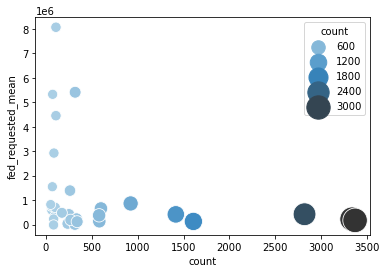

In [69]:
sns.scatterplot(
    data=prefix_subset, x="count", y="fed_requested_mean", hue="count", size="count", palette="Blues_d",
    sizes=(100, 600))

<AxesSubplot:xlabel='count', ylabel='ac_requested_mean'>

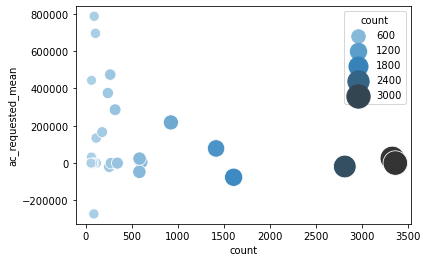

In [70]:
sns.scatterplot(
    data=prefix_subset, x="count", y="ac_requested_mean", hue="count", size="count", palette="Blues_d",
    sizes=(100, 600))

<AxesSubplot:xlabel='count', ylabel='total_requested_mean'>

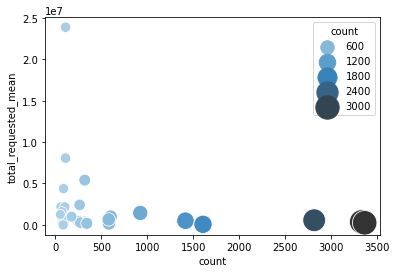

In [71]:
sns.scatterplot(
    data=prefix_subset, x="count", y="total_requested_mean", hue="count", size="count", palette="Blues_d",
    sizes=(100, 600))

<AxesSubplot:xlabel='count', ylabel='fed_requested_median'>

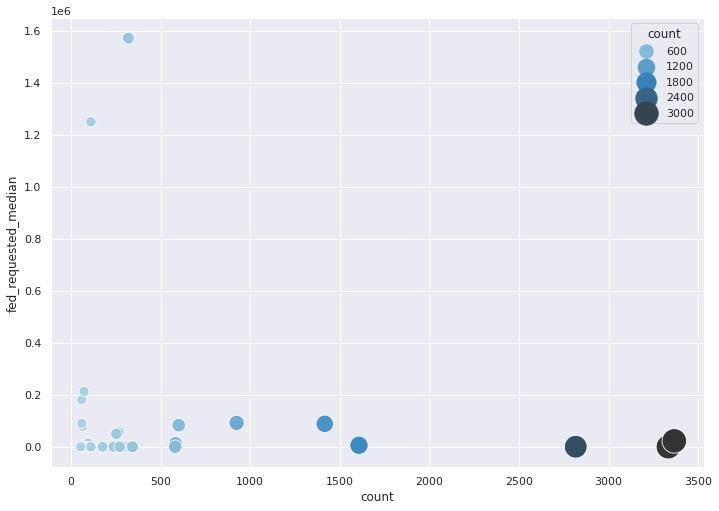

In [80]:
sns.scatterplot(
    data=prefix_subset, x="count", y="fed_requested_median", hue="count", size="count", palette="Blues_d",
    sizes=(100, 600))

<AxesSubplot:xlabel='count', ylabel='ac_requested_median'>

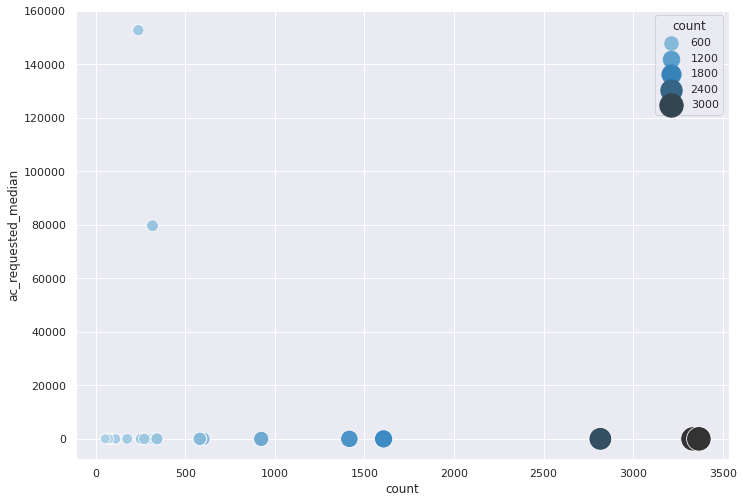

In [81]:
sns.scatterplot(
    data=prefix_subset, x="count", y="ac_requested_median", hue="count", size="count", palette="Blues_d",
    sizes=(100, 600))

<AxesSubplot:xlabel='count', ylabel='total_requested_median'>

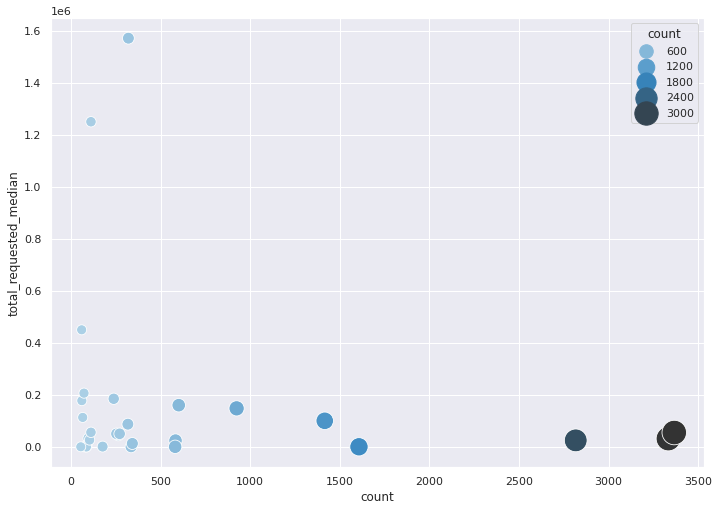

In [82]:
sns.scatterplot(
    data=prefix_subset, x="count", y="total_requested_median", hue="count", size="count", palette="Blues_d",
    sizes=(100, 600))

<AxesSubplot:xlabel='total_requested_mean', ylabel='count'>

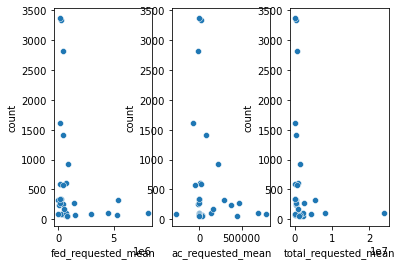

In [72]:
fig, axs = plt.subplots(ncols=3)
sns.scatterplot(x='fed_requested_mean', y='count', data=prefix_subset, ax=axs[0])
sns.scatterplot(x='ac_requested_mean', y='count', data=prefix_subset, ax=axs[1])
sns.scatterplot(x='total_requested_mean',y='count', data=prefix_subset, ax=axs[2])

<AxesSubplot:xlabel='total_requested_median', ylabel='count'>

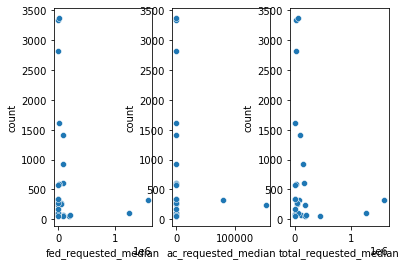

In [73]:
fig, axs = plt.subplots(ncols=3)
sns.scatterplot(x='fed_requested_median', y='count', data=prefix_subset, ax=axs[0])
sns.scatterplot(x='ac_requested_median', y='count', data=prefix_subset, ax=axs[1])
sns.scatterplot(x='total_requested_median',y='count', data=prefix_subset, ax=axs[2])

#### Combined Scatter for Mean/Median and Count

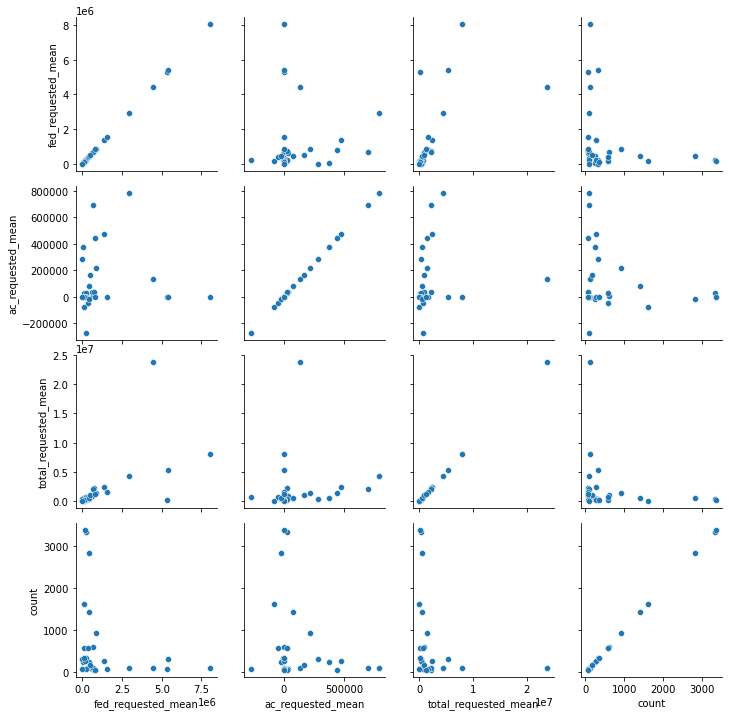

In [74]:
g = sns.PairGrid(prefix_subset, vars=["fed_requested_mean", "ac_requested_mean","total_requested_mean","count"])
g.map(sns.scatterplot)

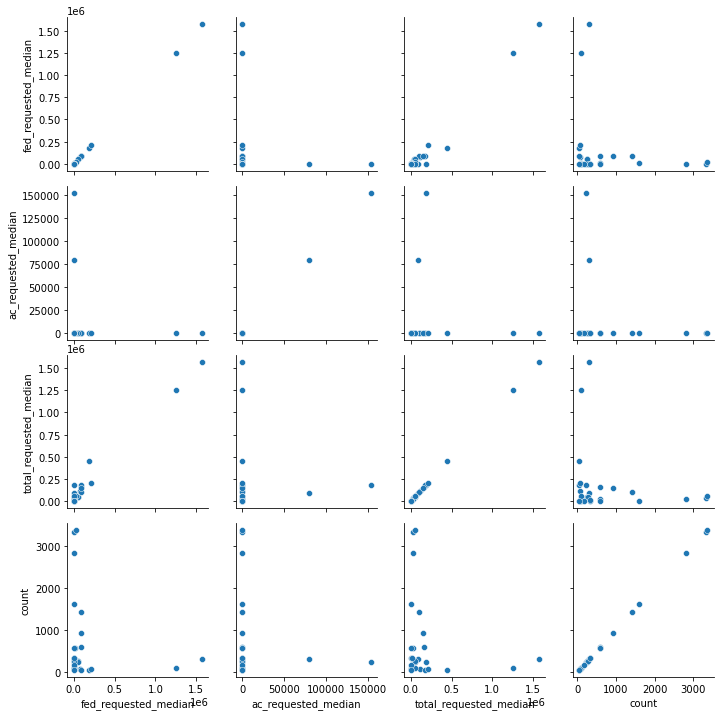

In [75]:
g = sns.PairGrid(prefix_subset, vars=["fed_requested_median", "ac_requested_median","total_requested_median","count"])
g.map(sns.scatterplot)

#### Barplots for Mean and Median

In [76]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

<AxesSubplot:xlabel='fed_requested_mean', ylabel='prefix'>

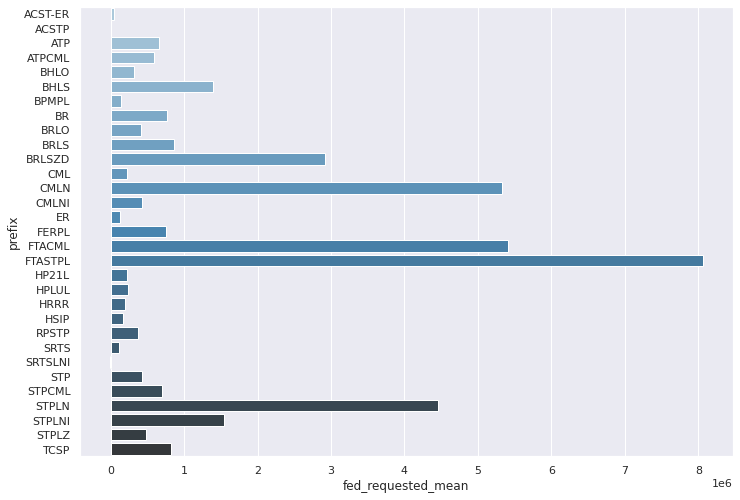

In [77]:
sns.barplot(x="fed_requested_mean", y="prefix", data=prefix_subset, palette="Blues_d")

<AxesSubplot:xlabel='ac_requested_mean', ylabel='prefix'>

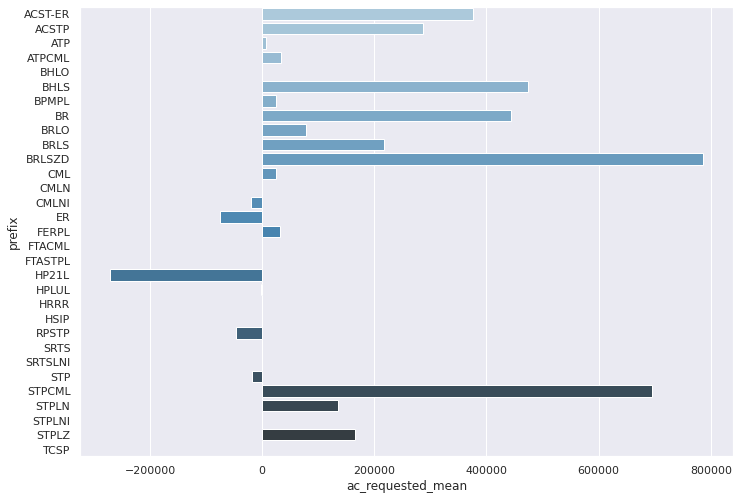

In [78]:
sns.barplot(x="ac_requested_mean", y="prefix", data=prefix_subset, palette="Blues_d")

<AxesSubplot:xlabel='total_requested_mean', ylabel='prefix'>

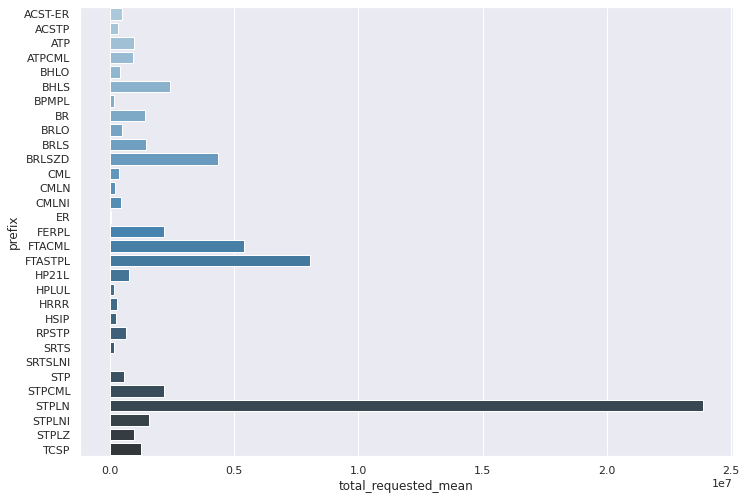

In [79]:
sns.barplot(x="total_requested_mean", y="prefix", data=prefix_subset, palette="Blues_d")

<AxesSubplot:xlabel='fed_requested_median', ylabel='prefix'>

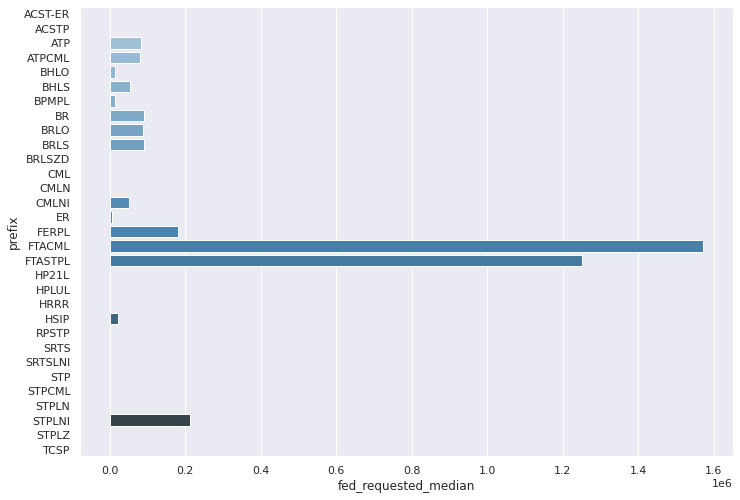

In [83]:
sns.barplot(x="fed_requested_median", y="prefix", data=prefix_subset, palette="Blues_d")

<AxesSubplot:xlabel='ac_requested_median', ylabel='prefix'>

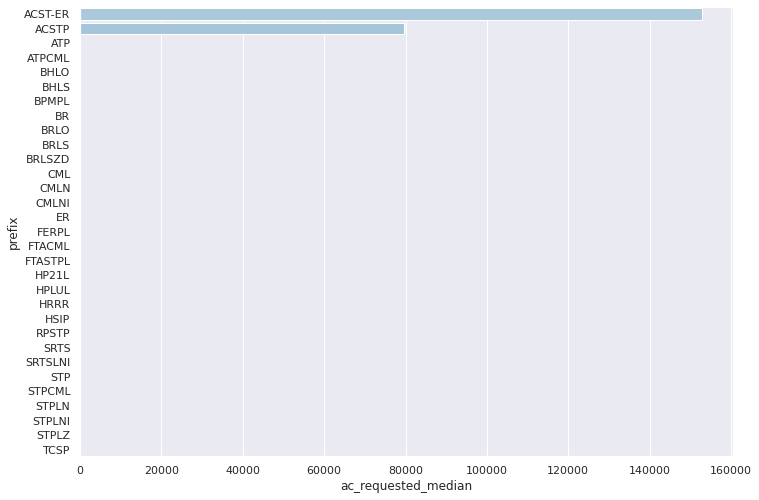

In [84]:
sns.barplot(x="ac_requested_median", y="prefix", data=prefix_subset, palette="Blues_d")

<AxesSubplot:xlabel='total_requested_median', ylabel='prefix'>

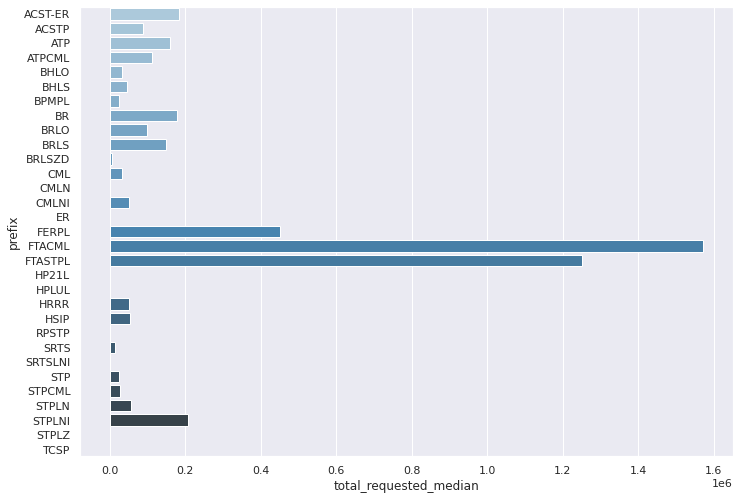

In [85]:
sns.barplot(x="total_requested_median", y="prefix", data=prefix_subset, palette="Blues_d")

## Looking at overall Agencies and MPOs

In [86]:
df.agency.value_counts()

Humboldt County                    631
Los Angeles                        543
Fresno                             467
Santa Cruz County                  455
Los Angeles County                 411
                                  ... 
Merced Co Aog                        1
Corning                              1
Napa County Office Of Education      1
Lgnw                                 1
Ala-Con Costa T                      1
Name: agency, Length: 671, dtype: int64

In [87]:
count_agency = pd.DataFrame(df.agency.value_counts())

In [88]:
count_agency.head()

,agency
Humboldt County,631
Los Angeles,543
Fresno,467
Santa Cruz County,455
Los Angeles County,411


Intersting that Humboldt has the highest count. Will investigate further in the **Identifying_Projects** Notebook

In [90]:
count_agency.tail()

,agency
Merced Co Aog,1
Corning,1
Napa County Office Of Education,1
Lgnw,1
Ala-Con Costa T,1


In [91]:
count_agency.agency.value_counts()

1      53
2      47
7      33
3      32
4      28
       ..
95      1
97      1
102     1
68      1
631     1
Name: agency, Length: 123, dtype: int64

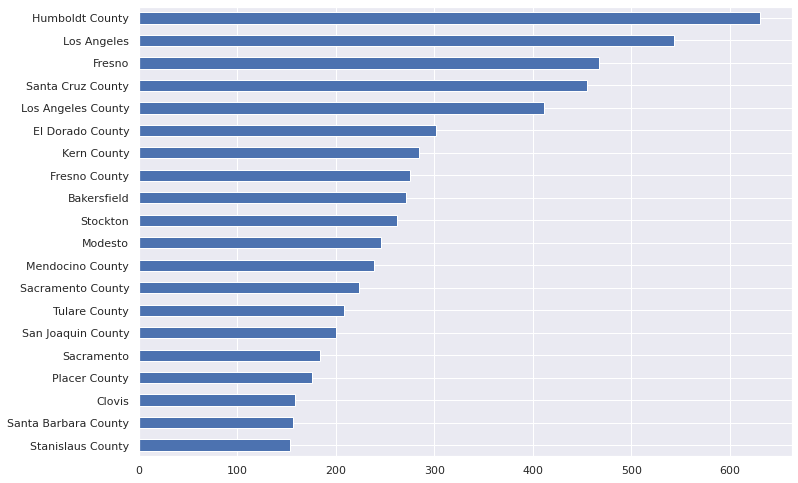

In [92]:
ax = df.agency.value_counts().iloc[:20].plot(kind="barh")
ax.invert_yaxis()

In [93]:
df.mpo.value_counts()

SCAG       5098
MTC        3293
NON-MPO    2618
SACOG      1889
CFCG       1429
KCOG       1009
STANCOG     767
AMBAG       758
SJCG        523
SDAG        501
TCAG        493
SBCG        346
MCAG        283
BCAG        256
SLAC        244
STPA        211
MCTC        199
KCAG        141
SANDAG      137
SJCOG       134
TMPO         48
COFCG        26
ER NONE      16
STACOG       10
STNCOG        3
NONMPO        3
FCOG          3
SLOCOG        2
MNOLTC        1
FSTIP         1
SHASTA        1
SANDA         1
Name: mpo, dtype: int64

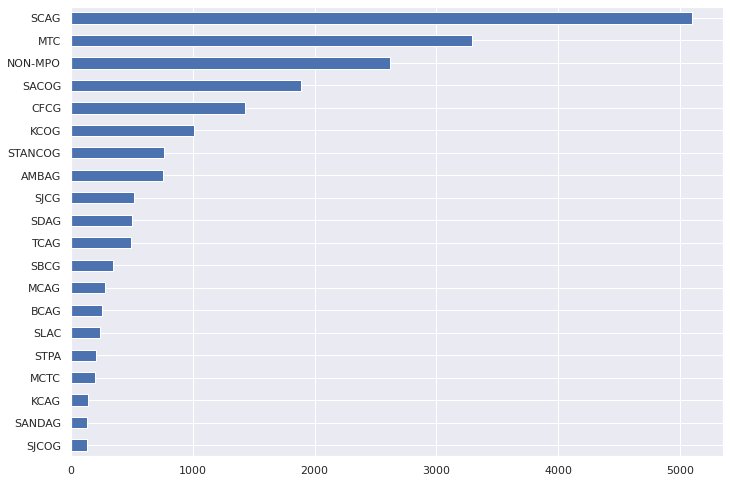

In [95]:
ax = df.mpo.value_counts().iloc[:20].plot(kind="barh")
ax.invert_yaxis()

## Looking at the Totals for each Prefix 

In [96]:
#trying something 

prefix_agency_count = df.groupby('prefix')[["agency"]].count().sort_values('agency', ascending=False)

In [97]:
prefix_agency_count['sum_total_obligations'] = df.groupby('prefix')[["total_requested"]].sum()

In [98]:
prefix_agency_count['sum_fed_obligations'] = df.groupby('prefix')[["fed_requested"]].sum()

In [99]:
prefix_agency_count['sum_ac_obligations'] = df.groupby('prefix')[["ac_requested"]].sum()

In [100]:
prefix_agency_count

,agency,sum_total_obligations,sum_fed_obligations,sum_ac_obligations
prefix,,,,
HSIP,3367,828314937.69,583393273.94,1140769.00
CML,3334,1194354302.25,742972302.34,84595809.00
STP,2817,1564114221.77,1193443713.98,-51002041.11
ER,1607,101920080.49,208132484.61,-121680830.60
BRLO,1416,705089017.96,591212939.92,111315684.18
...,...,...,...,...
RPMSTPL,1,834924.54,-57733.51,0.00
ESPLCM,1,2840093.10,0.00,0.00
ESPLEH,1,19913984.80,0.00,0.00


## Diving into indivudual Prefixes
### Looking at just HSIP
similar approach like the previous section 

In [101]:
df.head()

,Unnamed: 0,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode
0,0,Obligated,BPMPL,5904(121),Humboldt County,2018-12-18,2018-12-18,2018-12-18,2018-12-18,2018-12-27,0.00,0.00,0.00,Authorized,5904,1,E-76 approved on,NaN,0.00,9.00,HBPLOCAL,14 Bridges In Humboldt County,Bridge Preventive Maintenance - Deck Joints,3,NaN,NaN,NON-MPO,NaN,5904,121,True
1,1,Obligated,ER,32D0(008),Mendocino County,2018-12-17,2018-12-19,2018-12-20,2018-12-20,2018-12-27,11508.00,0.00,13000.00,Authorized,5910,1,E-76 approved on,1.00,1.00,7.00,NaN,"Comptche Ukiah Road, Cr 223 Pm 17.25",Permanent Restoration,3,2018-12-17,2018-12-18,NON-MPO,NaN,32D0,8,False
2,2,Obligated,ER,4820(004),Humboldt County,2018-12-07,2018-12-21,2018-12-21,2018-12-21,2018-12-27,45499.64,0.00,51394.58,Authorized,5904,1,E-76 approved on,14.00,0.00,6.00,NaN,Mattole Rd Pm 43.17,Permanent Restoration,5,2018-12-06,2018-12-07,NON-MPO,NaN,4820,4,False
3,3,Obligated,CML,5924(244),Sacramento County,2018-12-11,2018-12-11,2018-12-21,2018-12-27,2018-12-27,207002.00,0.00,247002.00,Authorized,5924,3,E-76 approved on,4.00,16.00,0.00,SAC25086,Fair Oaks Blvd. Between Howe Ave And Munroe St,Create A Smart Growth Corridor With Barrier Se...,1,2018-12-07,2018-12-07,SACOG,NaN,5924,244,True
4,4,Obligated,CML,5924(214),Sacramento County,2018-12-05,2018-12-11,2018-12-21,2018-12-27,2018-12-27,0.00,5680921.00,5702041.00,Authorized,5924,3,E-76 approved on,7.00,16.00,0.00,SAC24753,Florin Rd Between Power Inn Rd. And Florin Per...,Streetscape (tc),3,2018-11-28,2018-12-04,SACOG,NaN,5924,214,True


In [102]:
hsip = df[(df['prefix']=='HSIP')]


In [103]:
hsip

,Unnamed: 0,location,prefix,project_no,agency,prepared_date,submit__to_hq_date,hq_review_date,submit_to_fhwa_date,to_fmis_date,fed_requested,ac_requested,total_requested,status_comment,locode,dist,status,dist_processing_days,hq_processing_days,fhwa_processing_days,ftip_no,project_location,type_of_work,seq,date_request_initiated,date_completed_request,mpo,warning,projectID,projectNO,compare_id_locode
11,11,Obligated,HSIP,5378(045),Palmdale,2018-12-11,2018-12-18,2018-12-27,2018-12-27,2018-12-27,545800.00,0.00,735764.00,Authorized,5378,7,E-76 approved on,8.00,9.00,0.00,SCAG015,Various Locations Citywide.,Upgrade Guard Rail And End Treatments,2,2018-12-04,2018-12-10,SCAG,NaN,5378,45,True
17,17,Obligated,HSIP,5385(060),Ridgecrest,2018-12-11,2018-12-18,2018-12-19,2018-12-20,2018-12-23,195500.00,0.00,195500.00,Authorized,5385,9,E-76 approved on,0.00,2.00,3.00,KER140601,Graaf Ave. At Alene Ave.; Drummond Ave. At San...,Install Rrfb's With Signage And Striping And U...,2,2018-12-11,2018-12-18,KCOG,NaN,5385,60,True
32,32,Obligated,HSIP,5385(059),Ridgecrest,2018-11-27,2018-12-18,2018-12-19,2018-12-20,2018-12-21,135200.00,0.00,135200.00,Authorized,5385,9,E-76 approved on,0.00,2.00,1.00,KER140601,Downs St. And Bowman Rd. Intersection,"Safety Signs, And Striping",2,2018-11-30,2018-12-18,KCOG,NaN,5385,59,True
39,39,Obligated,HSIP,5924(227),Sacramento County,2018-12-11,2018-12-13,2018-12-14,2018-12-18,2018-12-19,1413500.00,0.00,1413500.00,Authorized,5924,3,E-76 approved on,0.00,5.00,1.00,SAC25030,39 County Intersections On Portions Of Winding...,Upgrade Signals To Allow For Traffic Responsiv...,2,2018-12-07,2018-12-13,SACOG,NaN,5924,227,True
44,44,Obligated,HSIP,5108(178),Long Beach,2018-12-11,2018-12-11,2018-12-13,2018-12-14,2018-12-19,166500.00,0.00,366500.00,Authorized,5108,7,E-76 approved on,0.00,3.00,5.00,SCAG015,Anaheim Street: La River -pacific Coast Hwy,"Install Controller Access Medians, Signal Upgr...",1,2018-12-11,2018-12-11,SCAG,NaN,5108,178,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20424,20426,Obligated,HSIP,5066(027),National City,2021-10-01,2021-10-01,2021-10-01,2021-10-01,2021-10-15,0.00,0.00,0.00,Authorized,5066,11,E-76 approved on,8.00,0.00,14.00,CAL105/CAL334,"Highland Ave/ E 4th St, Highland Ave/shopping ...",Upgrade Traffic Signals; Install Protected Lef...,4,2021-09-23,2021-09-24,SDAG,NaN,5066,27,True
20425,20427,Obligated,HSIP,5066(029),National City,2021-10-01,2021-10-01,2021-10-01,2021-10-01,2021-10-15,0.00,0.00,0.00,Authorized,5066,11,E-76 approved on,8.00,0.00,14.00,CAL105 /,9 Intersections Throughout National City.,Install Pedestrian Crossings And Related Impro...,4,2021-09-23,2021-09-24,SDAG,NaN,5066,29,True
20432,20434,Obligated,HSIP,5073(086),Orange,2021-09-24,2021-09-24,2021-10-19,2021-10-19,2021-10-21,-646.92,0.00,1033.76,Authorized,5073,12,E-76 approved on,8.00,25.00,2.00,SCAG015,12 Various Signalized Intersections Located Th...,Upgrade The Accessible Pedestrian Signals (aps),4,2021-09-16,2021-09-17,SCAG,NaN,5073,86,True
20434,20436,Obligated,HSIP,5181(184),Huntington Beach,2021-10-18,2021-10-18,2021-10-18,2021-10-18,2021-10-22,-49587.18,0.00,-55004.80,Authorized,5181,12,E-76 approved on,4.00,0.00,4.00,SCAG015,Goldenwest Street From Warner Avenue To Heil A...,Install Signal Interconnect Conduit And Upgrad...,5,2021-10-14,2021-10-15,SCAG,NaN,5181,184,True


In [104]:
hsip[['dist_processing_days','hq_processing_days','fhwa_processing_days']].describe()

,dist_processing_days,hq_processing_days,fhwa_processing_days
count,3117.00,3339.00,3339.00
mean,22.20,8.64,5.97
std,52.25,13.46,4.79
min,-142.00,0.00,0.00
25%,0.00,0.00,2.00
50%,6.00,4.00,5.00
75%,19.00,11.00,8.00
max,1098.00,156.00,41.00


In [105]:
hsip.location.value_counts()

Obligated    3329
DISTRICT       26
FMIS            9
HQ              3
Name: location, dtype: int64

In [106]:
hsip.status_comment.value_counts()

Authorized                                                               3329
..                                                                         31
Hold for FTIP amendment.                                                    1
EXPIRED QAP                                                                 1
ON HOLD FOR DEOBLIGATION NOT PERMITTED AT THIS TIME                         1
ON HOLD FOR COST ESTIMATE CLARIFICATION & CE OVER 15% JUSTIFICATION         1
EPSP; JUSTIFICATION FOR PED EXTENSION FOR PE                                1
Hold verification of funding.                                               1
prog code Z300                                                              1
Name: status_comment, dtype: int64

### By Agency

In [107]:
hsip.agency.value_counts()

Stockton              92
Los Angeles           77
Los Angeles County    77
Fresno                64
Orange                57
                      ..
Gardena                1
Rsm                    1
Daly City              1
Westlake Village       1
Caltrans               1
Name: agency, Length: 297, dtype: int64

In [108]:
hsip.agency.value_counts().mean()

11.336700336700337

In [109]:
hsip.agency.value_counts().describe()

count   297.00
mean     11.34
std      13.39
min       1.00
25%       3.00
50%       7.00
75%      14.00
max      92.00
Name: agency, dtype: float64

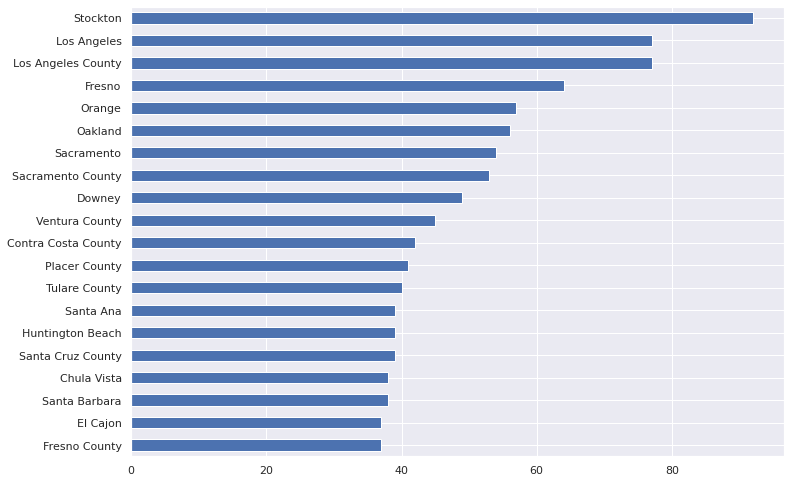

In [110]:
ax = hsip.agency.value_counts().iloc[:20].plot(kind="barh")
ax.invert_yaxis()

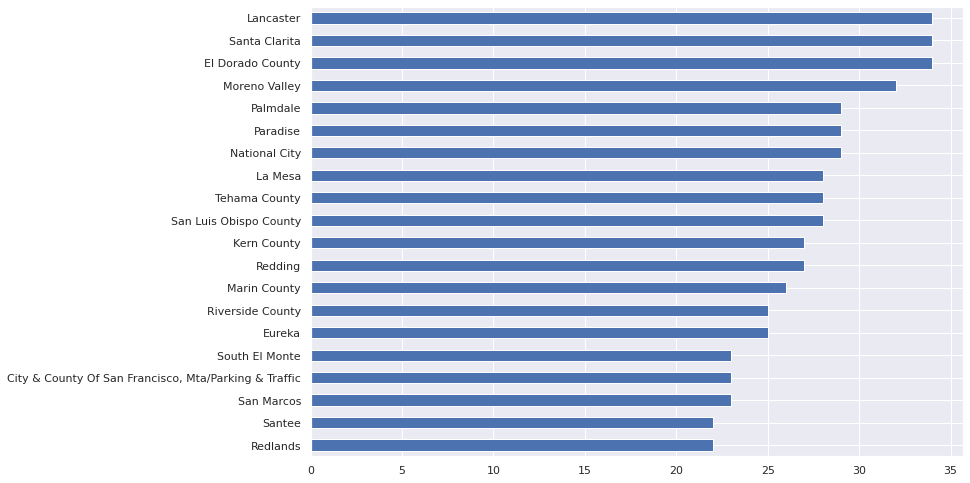

In [111]:
ax = hsip.agency.value_counts().iloc[20:40].plot(kind="barh")
ax.invert_yaxis()

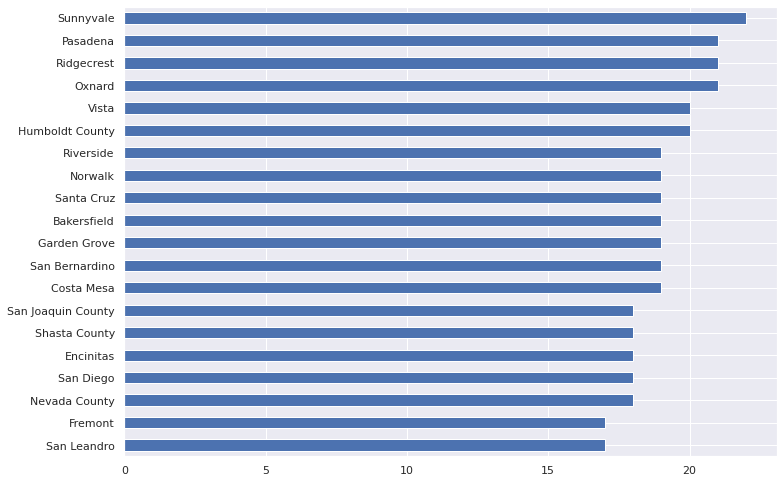

In [112]:
ax = hsip.agency.value_counts().iloc[40:60].plot(kind="barh")
ax.invert_yaxis()

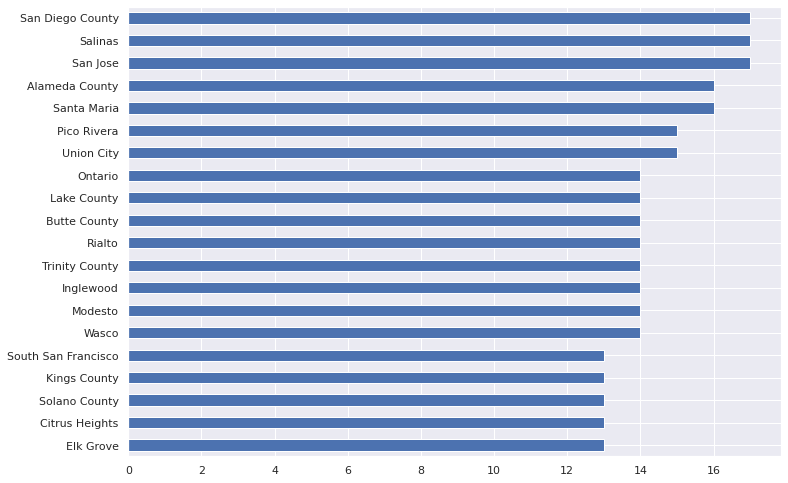

In [113]:
ax = hsip.agency.value_counts().iloc[60:80].plot(kind="barh")
ax.invert_yaxis()

### By MPO

In [114]:
hsip.mpo.nunique()

26

In [115]:
hsip.mpo.value_counts()

SCAG       1275
MTC         458
SACOG       288
NON-MPO     225
SDAG        203
CFCG        140
KCOG        110
AMBAG       105
SJCG         98
TCAG         71
SBCG         70
STANCOG      59
BCAG         59
STPA         52
SLAC         39
MCAG         29
SJCOG        26
SANDAG       23
KCAG         14
MCTC         10
COFCG         5
ER NONE       2
NONMPO        2
SHASTA        1
STNCOG        1
TMPO          1
Name: mpo, dtype: int64

In [116]:
#makes sense given Los Angeles, Los Angeles County and Orange are in the top 5 when broken 
##down by agency



<AxesSubplot:>

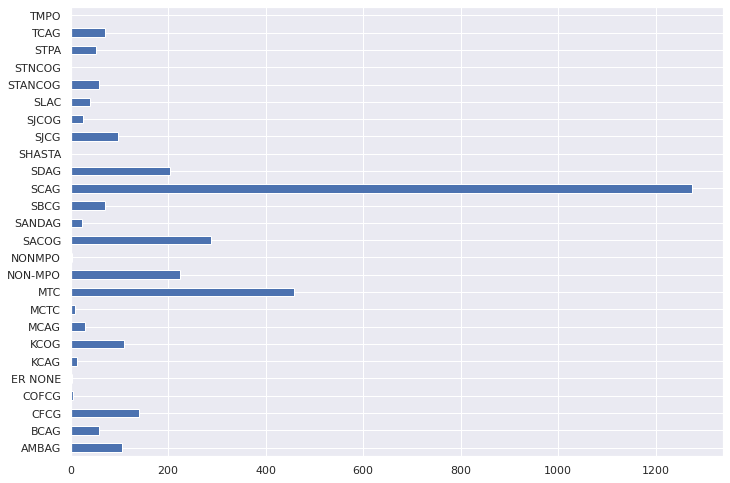

In [120]:
hsip.mpo.value_counts().sort_index(ascending=True).plot(kind="barh")

In [118]:
#mpo_bounds

In [127]:
#mpo_bounds2

### Checking SEQ Column
Where the 

In [121]:
hsip.seq.value_counts().sort_index(ascending=True)

1    807
2    923
3    810
4    508
5    230
6     60
7     23
8      4
9      2
Name: seq, dtype: int64

<AxesSubplot:>

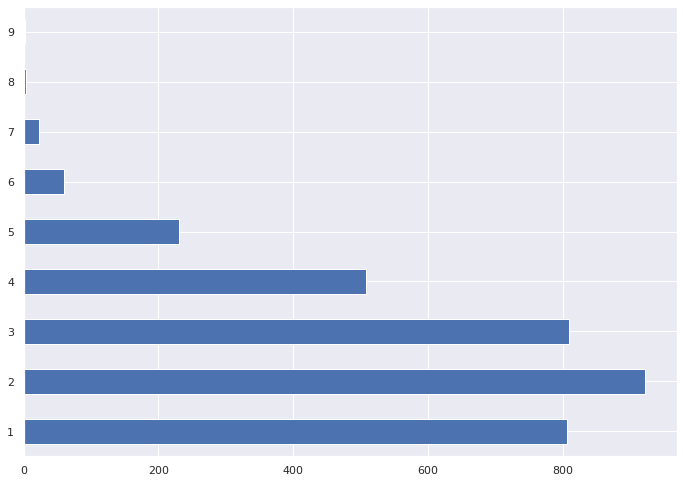

In [122]:
hsip.seq.value_counts().sort_index(ascending=True).plot(kind="barh")

In [123]:
hsip.groupby("seq")[["total_requested"]].describe()

total_requested                                                      \
              count      mean       std         min       25%       50%   
seq                                                                       
1            807.00 295576.48 649700.55     2300.00  51100.00 120600.00   
2            923.00 475066.84 764651.56 -2366000.00  13239.36 235667.00   
3            810.00 145625.27 551370.52 -2893110.00 -18822.41   3222.00   
4            508.00  37352.76 312981.83 -2069637.14 -25101.21      0.00   
5            230.00  43368.30 223004.03  -272965.59  -1091.24      0.00   
6             60.00  73000.44 368417.71  -572440.41     -4.53      0.00   
7             23.00  -5314.01 175050.63  -708440.00   -987.63      0.00   
8              4.00  33460.57 144677.34  -103836.22 -25959.06      0.00   
9              2.00      0.00      0.00        0.00      0.00      0.00   

                          
          75%        max  
seq                       
1   275000.00 8670556.00  
2   676978.50 7449709.00  
3   149686.00 5293800.00  
4    30563.28 3594545.00  
5     7017.57 2105791.00  
6        0.00 2407071.38  
7     1763.63  301785.23  
8    59419.63  237678.52  
9        0.00       0.00